In [1]:
from zipfile import ZipFile
import os

# Path to the zip file
zip_file_path = '/content/train.zip'

# Directory to extract the files to
extract_dir = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of zip file in current directory
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:")
for file in extracted_files:
    print(file)

Extracted files:
.config
train.zip
train
sample_data


In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_images_and_labels(base_dir, target_size=(256, 256)):
    images = []
    labels = []
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                try:
                    file_path = os.path.join(folder_path, file)
                    img = Image.open(file_path)
                    img = img.resize(target_size).convert('RGB')
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(folder)
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(labels)

base_dir = '/content/train'  # Change this to your dataset's base directory
images, labels = load_images_and_labels(base_dir)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Preprocess the data
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Cross-validation setup
kf = StratifiedKFold(n_splits=5)

# Initialize result storage
results = {'Algorithm': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}

5/5 [==============================] - 0s 19ms/step


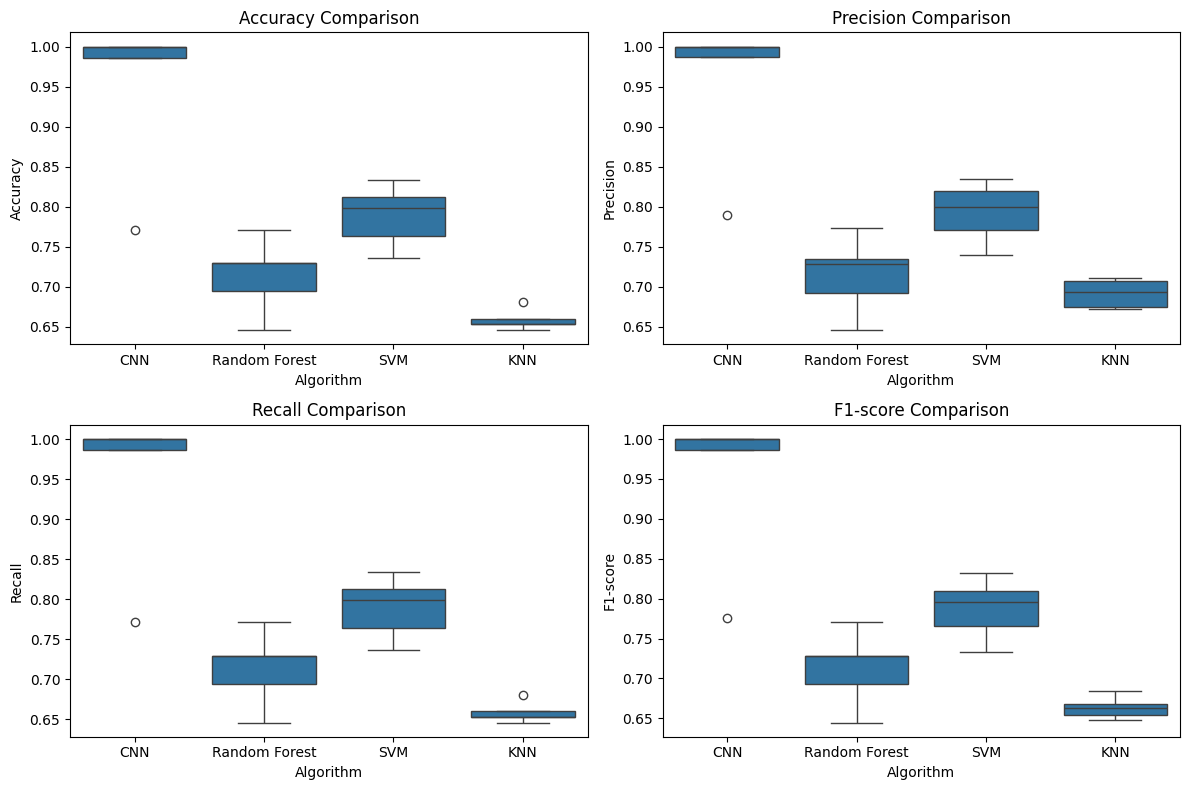

In [4]:
# Train and evaluate each algorithm
for train_index, test_index in kf.split(X_train, y_train_encoded):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train_encoded[train_index], y_train_encoded[test_index]

    # Train CNN
    X_train_fold_cnn = X_train_fold.astype('float32') / 255.0
    X_test_fold_cnn = X_test_fold.astype('float32') / 255.0
    model_cnn.fit(X_train_fold_cnn, y_train_fold, epochs=10, verbose=0)
    cnn_pred = np.argmax(model_cnn.predict(X_test_fold_cnn), axis=1)
    results['Algorithm'].append('CNN')
    results['Accuracy'].append(accuracy_score(y_test_fold, cnn_pred))
    results['Precision'].append(precision_score(y_test_fold, cnn_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test_fold, cnn_pred, average='weighted'))
    results['F1-score'].append(f1_score(y_test_fold, cnn_pred, average='weighted'))

    # Train Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold)
    rf_pred = rf.predict(X_test_fold.reshape(X_test_fold.shape[0], -1))
    results['Algorithm'].append('Random Forest')
    results['Accuracy'].append(accuracy_score(y_test_fold, rf_pred))
    results['Precision'].append(precision_score(y_test_fold, rf_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test_fold, rf_pred, average='weighted'))
    results['F1-score'].append(f1_score(y_test_fold, rf_pred, average='weighted'))

    # Train SVM
    svm = SVC()
    svm.fit(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold)
    svm_pred = svm.predict(X_test_fold.reshape(X_test_fold.shape[0], -1))
    results['Algorithm'].append('SVM')
    results['Accuracy'].append(accuracy_score(y_test_fold, svm_pred))
    results['Precision'].append(precision_score(y_test_fold, svm_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test_fold, svm_pred, average='weighted'))
    results['F1-score'].append(f1_score(y_test_fold, svm_pred, average='weighted'))

    # Train KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold)
    knn_pred = knn.predict(X_test_fold.reshape(X_test_fold.shape[0], -1))
    results['Algorithm'].append('KNN')
    results['Accuracy'].append(accuracy_score(y_test_fold, knn_pred))
    results['Precision'].append(precision_score(y_test_fold, knn_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test_fold, knn_pred, average='weighted'))
    results['F1-score'].append(f1_score(y_test_fold, knn_pred, average='weighted'))

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))

# Accuracy boxplot
plt.subplot(2, 2, 1)
sns.boxplot(x='Algorithm', y='Accuracy', data=results_df)
plt.title('Accuracy Comparison')

# Precision boxplot
plt.subplot(2, 2, 2)
sns.boxplot(x='Algorithm', y='Precision', data=results_df)
plt.title('Precision Comparison')

# Recall boxplot
plt.subplot(2, 2, 3)
sns.boxplot(x='Algorithm', y='Recall', data=results_df)
plt.title('Recall Comparison')

# F1-score boxplot
plt.subplot(2, 2, 4)
sns.boxplot(x='Algorithm', y='F1-score', data=results_df)
plt.title('F1-score Comparison')

plt.tight_layout()
plt.show()

In [15]:
# Assuming you have already loaded the images and labels
class_labels = np.unique(labels)

# Print the classes
print("Classes:")
for label in class_labels:
    print(label)


Classes:
Tomato___Early_blight
Tomato___Late_blight
Tomato___healthy


In [5]:
# Print accuracy for each model
print("Accuracy for each model:")
for algorithm in results_df['Algorithm'].unique():
    accuracy_mean = results_df[results_df['Algorithm'] == algorithm]['Accuracy'].mean()
    print(f"{algorithm}: {accuracy_mean}")


Accuracy for each model:
CNN: 0.951388888888889
Random Forest: 0.7138888888888888
SVM: 0.788888888888889
KNN: 0.6583333333333334


In [6]:
import matplotlib.pyplot as plt

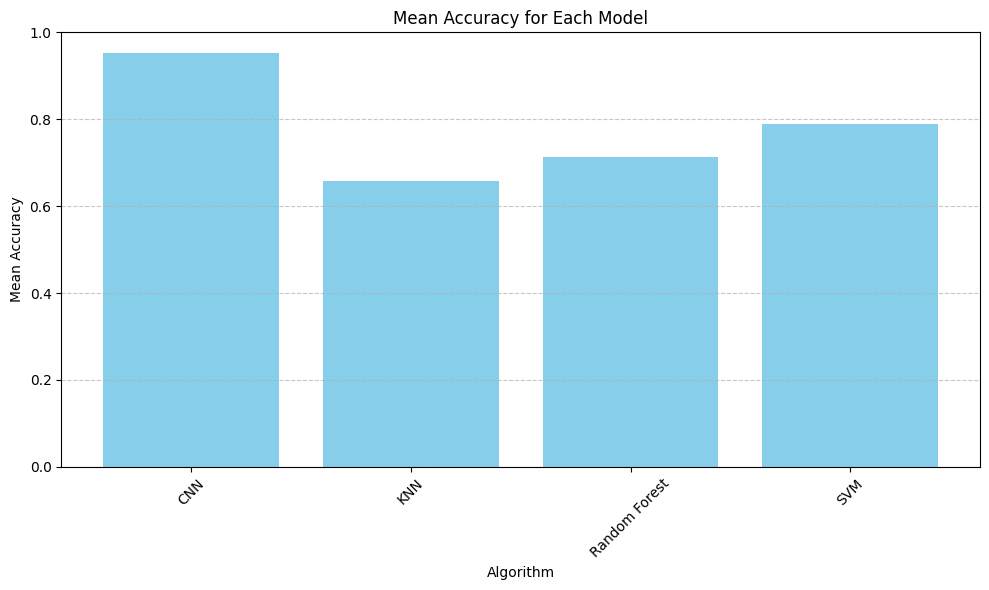

In [7]:
# Calculate mean accuracy for each algorithm
mean_accuracies = results_df.groupby('Algorithm')['Accuracy'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(mean_accuracies.index, mean_accuracies.values, color='skyblue')
plt.title('Mean Accuracy for Each Model')
plt.xlabel('Algorithm')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Limit y-axis to range from 0 to 1 for accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

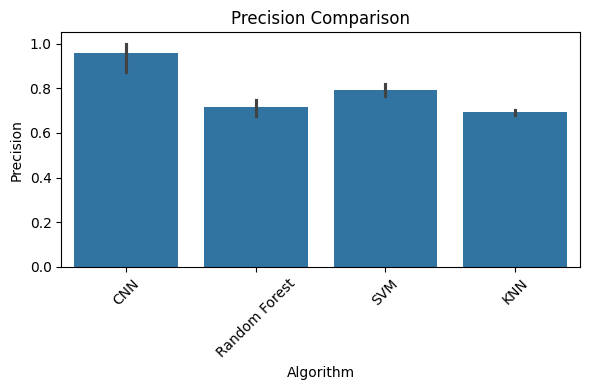

In [10]:
# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Plotting precision
plt.figure(figsize=(6, 4))
sns.barplot(x='Algorithm', y='Precision', data=results_df)
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

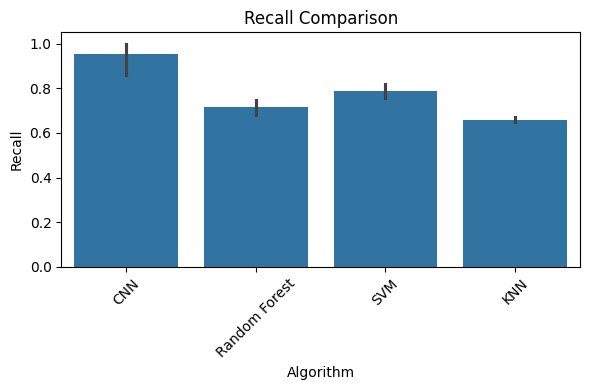

In [11]:
# Plotting recall
plt.figure(figsize=(6, 4))
sns.barplot(x='Algorithm', y='Recall', data=results_df)
plt.title('Recall Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

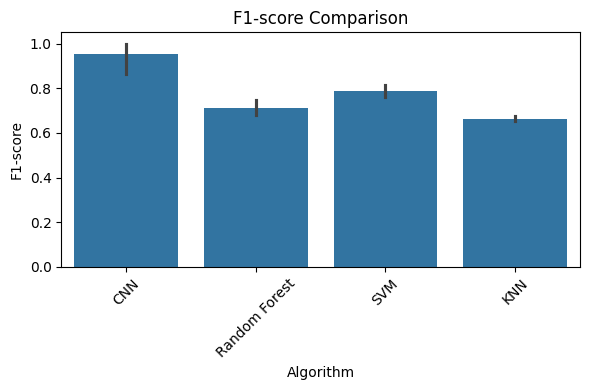

In [12]:
# Plotting F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x='Algorithm', y='F1-score', data=results_df)
plt.title('F1-score Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

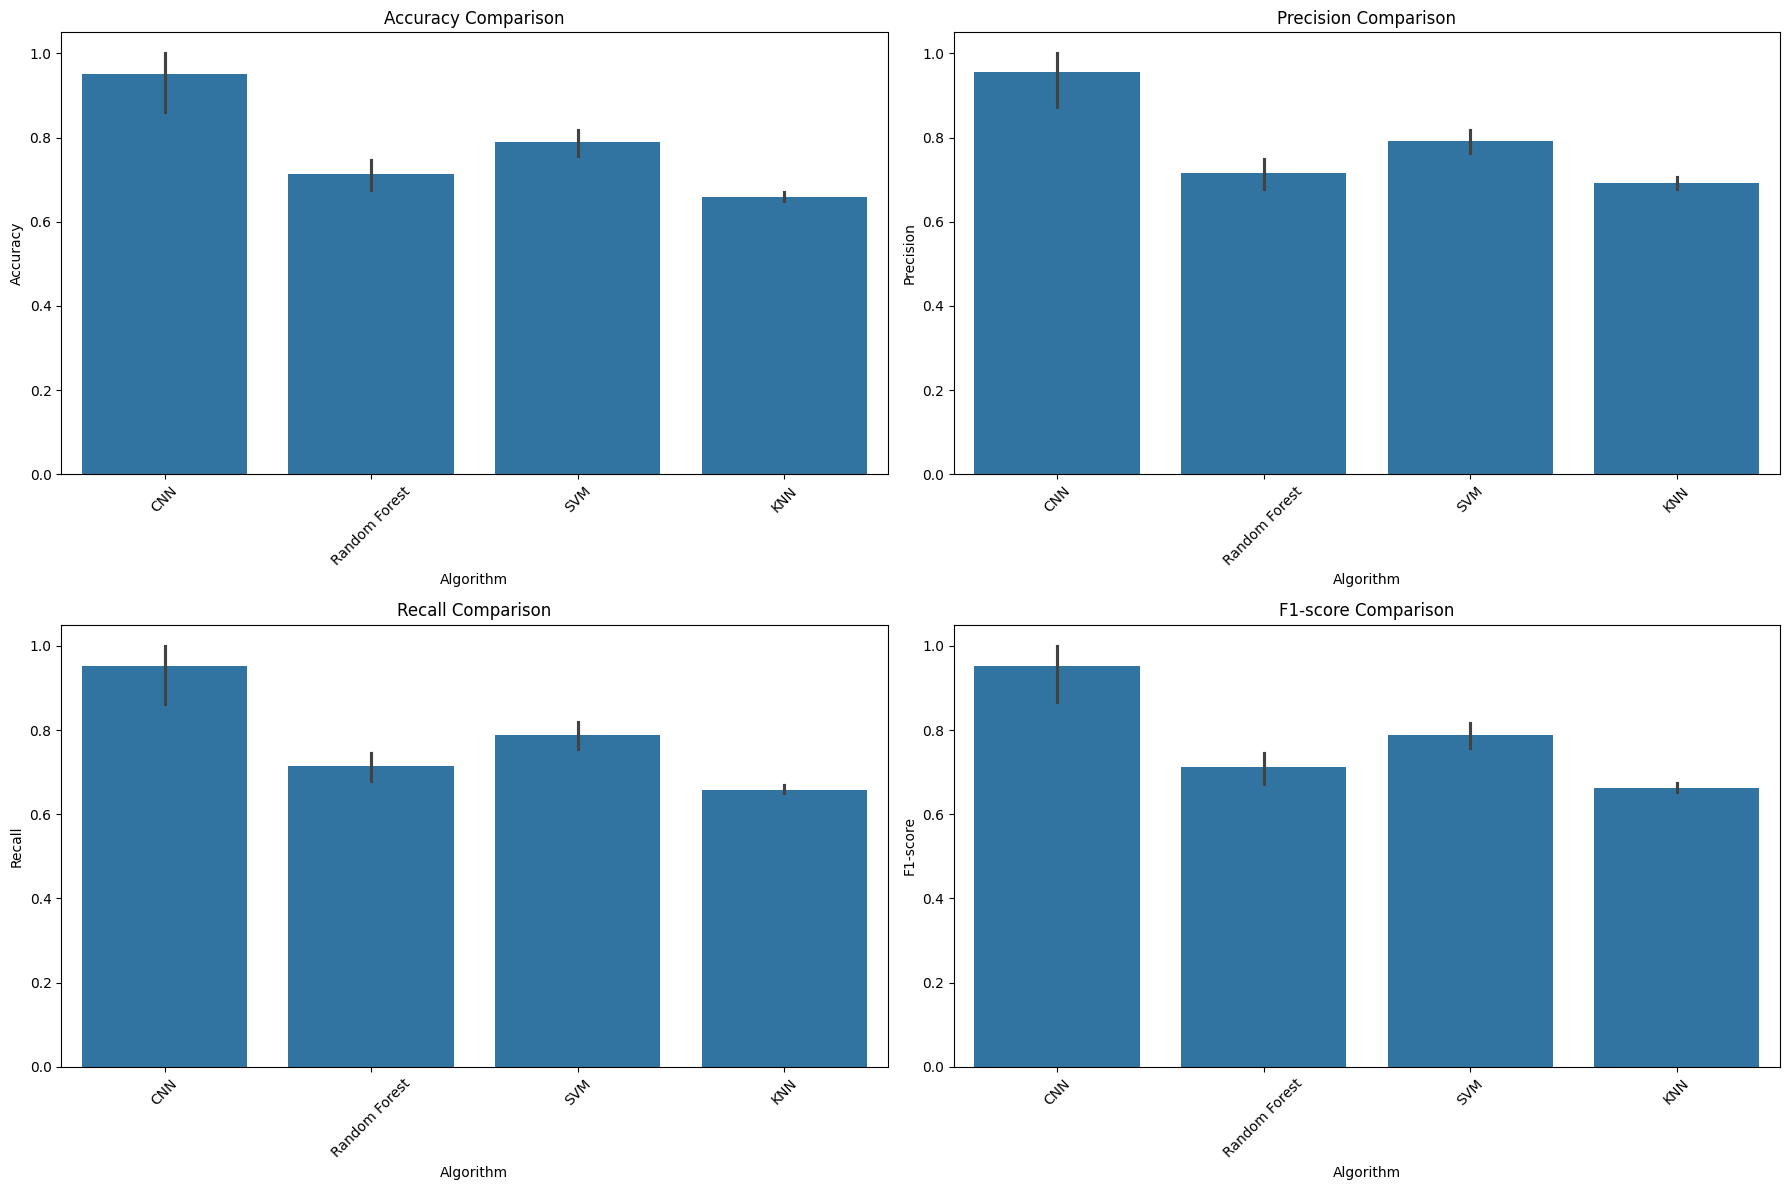

In [9]:
# Plotting
plt.figure(figsize=(18, 12))

# Metrics to plot
metrics = ['Accuracy','Precision', 'Recall', 'F1-score']

# Plot each metric
for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Algorithm', y=metric, data=results_df)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()